In [1]:
%load_ext autoreload
%autoreload 2

### Carla tracks explorative data analysis

Main task of this notebook is to get a sense for the carla data.

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial import distance
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, LineString
import pandas as pd
#from src.generate_traffic_data import clean_carla, spawn_scene, run_scene
import carla
import os
os.getcwd()
from datetime import datetime
import time
import random
from tqdm import tqdm
import networkx as nx
import numpy as np


os.chdir('../..')
os.getcwd()

from graph_creator.MapGraph import MapGraph
from graph_creator.ActorGraph import ActorGraph

In [3]:
# client = carla.Client('localhost', 2000)
# client.set_timeout(10.0)
# world = client.get_world()
# world_map = world.get_map()

### Read map graph and tracks and try to create actor graph.

In [4]:
g_map = MapGraph()
#g = give_it_a_try.create_from_carla_map(world_map)
#g.store_graph_to_file('test.pickle')
#give_it_a_try.visualize_graph()
#g.visualize_graph()
# type(g)
# g.graph.nodes

In [5]:
g_map.read_graph_from_file('/home/tmuehlen/repos/graph_coverage/carla/data/scene_0_2025-03-23_map_graph.pickle')

In [6]:
pd.DataFrame(g_map.graph.nodes(data=True))
g_map.graph.nodes(data=True)

NodeDataView({'2358_-1': {'lane_type': 'Driving', 'is_intersection': True, 'left_mark_type': 'NONE', 'right_mark_type': 'NONE', 'length': 32.625074416399, 'lane_polygon': <POLYGON ((15.162 203.391, 31.532 179.158, 31.55 175.658, 15.18 199.891, 15....>}, '27_-1': {'lane_type': 'Driving', 'is_intersection': False, 'left_mark_type': 'SolidSolid', 'right_mark_type': 'Broken', 'length': 21.419998183846474, 'lane_polygon': <POLYGON ((33.291 177.408, 33.3 155.738, 29.8 155.737, 29.791 177.407, 33.29...>}, '2343_2': {'lane_type': 'Driving', 'is_intersection': True, 'left_mark_type': 'Solid', 'right_mark_type': 'Broken', 'length': 28.749999925494194, 'lane_polygon': <POLYGON ((44.214 193.037, 15.214 192.891, 15.197 196.391, 44.196 196.537, 4...>}, '37_2': {'lane_type': 'Driving', 'is_intersection': False, 'left_mark_type': 'Solid', 'right_mark_type': 'Broken', 'length': 799.1102784052491, 'lane_polygon': <POLYGON ((15.214 192.891, 7.124 -195.233, 7.107 -191.733, 15.197 196.391, 1...>}, '2343_3'

In [7]:
pd.DataFrame(g_map.graph.edges(data=True))


,0,1,2
0,2358_-1,27_-1,{'edge_type': 'following'}
1,27_-1,2084_-1,{'edge_type': 'following'}
2,27_-1,27_-2,{'edge_type': 'neighbor'}
3,27_-1,27_1,{'edge_type': 'opposite'}
4,2343_2,37_2,{'edge_type': 'following'}
...,...,...,...
1213,1605_1,26_-2,{'edge_type': 'following'}
1214,1756_1,51_1,{'edge_type': 'following'}
1215,1756_1,1756_2,{'edge_type': 'neighbor'}
1216,1756_2,51_2,{'edge_type': 'following'}


In [8]:
tracks = pd.read_parquet('/home/tmuehlen/repos/graph_coverage/carla/data/scene_0_2025-03-23_tracks.parquet')
tracks['road_lane_id'] = tracks.road_id.astype(str) + '_' + tracks.lane_id.astype(str)
print(tracks.shape)

timestamps = tracks.timestamp.unique().tolist()
actors = tracks.actor_id.unique().tolist()
tracks.head(2).T

(12500, 24)


,0,1
actor_id,162,161
actor_type,vehicle.carlamotors.carlacola,vehicle.lincoln.mkz_2020
actor_speed_xyz,"[0.0, 0.0, -0.4899999797344208]","[0.0, 0.0, -0.4899999797344208]"
actor_acceleration_xyz,"[0.0, 0.0, -9.799999237060547]","[0.0, 0.0, -9.799999237060547]"
actor_location_xyz,"[151.52549743652344, 5.319231986999512, 0.5853...","[-217.58859252929688, 6.672847747802734, 0.285..."
actor_bbox,"[[-2.601919174194336, -1.3134948015213013, -1....","[[-2.452479839324951, -0.9183561205863953, 0.0..."
distance_till_lane_end,6.706502,15.002349
distance_from_lane_start,17.749999,39.999982
t_per_lane_id,0.0,0.093889
lane_id,-1,2


In [9]:
tracks.timestamp.nunique()

500

In [10]:
ag = ActorGraph()
ag_carla = ag.from_carla_scenario(tracks, g_map, max_distance_lead_veh_m=120)
ag_carla.actor_graphs.keys()

{'162': ['vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', 'vehicle.carlamotors.carlacola', '

100%|██████████| 13/13 [00:00<00:00, 18.56it/s]


dict_keys([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])

In [11]:
#ag._create_track_data_carla(tracks)


In [12]:
# clean up the graphs and components:

#ag_carla.actor_components[t_idx][i].size()
keys = list(ag_carla.actor_graphs.keys())
for  key in keys:
    ag_carla.actor_components[key] = [ag_carla.actor_components[key][i] for i in range(len(ag_carla.actor_components[key])) if ag_carla.actor_components[key][i].size() > 1]


/home/tmuehlen/repos/graph_coverage/graph_creator/ActorGraph.py:573: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


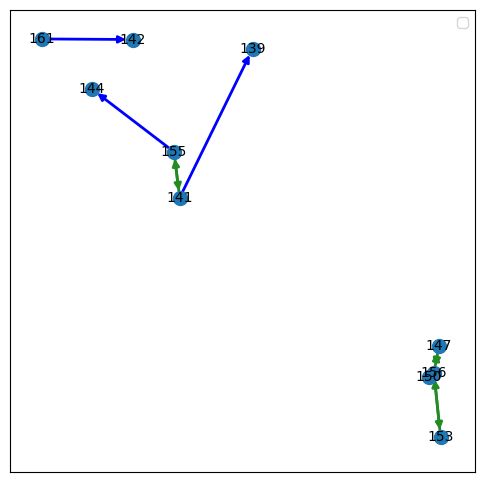

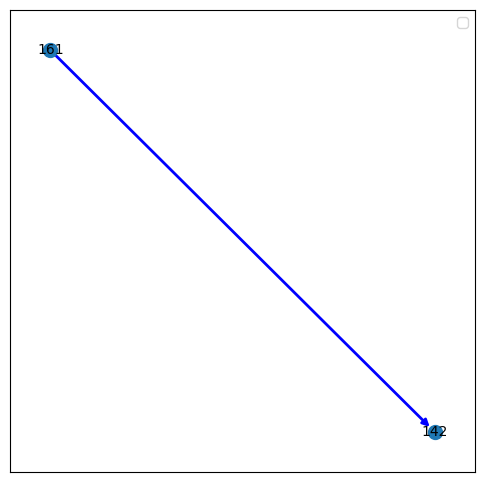

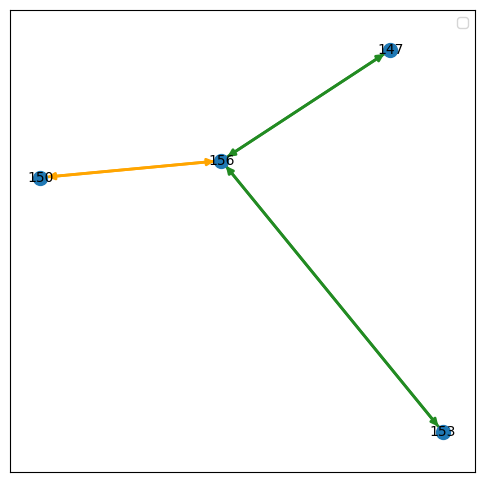

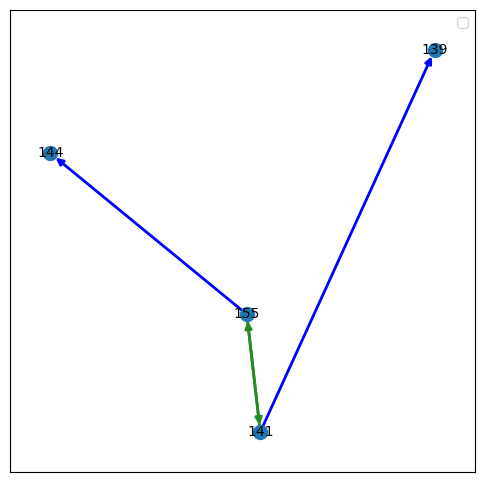

In [13]:
t_idx = 24
ag_carla.visualize_actor_graph(t_idx = t_idx, comp_idx = 0, use_map_pos=True, node_size = 100, graph_or_component='graph')
for i in range(len(ag_carla.actor_components[t_idx])):
    if ag_carla.actor_components[t_idx][i].size() > 1:
        ag_carla.visualize_actor_graph(t_idx = t_idx, comp_idx = i, use_map_pos=True, node_size = 100, graph_or_component='component')


### Start comparing graphs:

/home/tmuehlen/repos/graph_coverage/graph_creator/ActorGraph.py:573: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


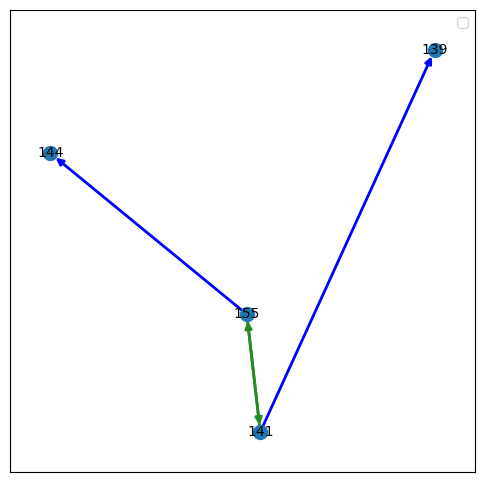

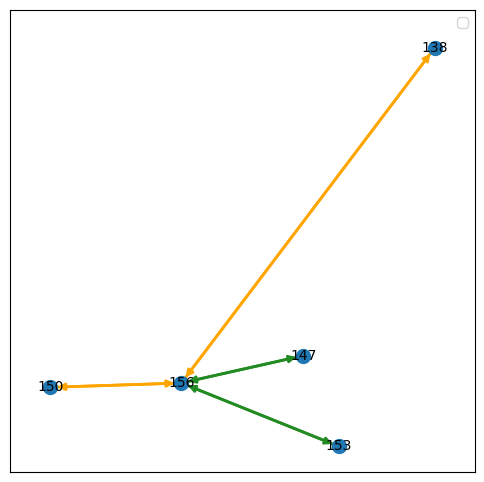

In [30]:
t_idx = 24
comp_idx = 2
G1 = ag_carla.actor_components[t_idx][comp_idx]
ag_carla.visualize_actor_graph(t_idx = t_idx, comp_idx = comp_idx, use_map_pos=True, node_size = 100, graph_or_component='component')
t_idx = 2
comp_idx = 1
G2 = ag_carla.actor_components[t_idx][comp_idx]
ag_carla.visualize_actor_graph(t_idx = t_idx, comp_idx = comp_idx, use_map_pos=True, node_size = 100, graph_or_component='component')


In [15]:
# node statistics:

print('degrees:', G.degree())



degrees: [('141', 4), ('139', 2), ('155', 4), ('144', 2)]


In [ ]:
# graph statistics:
print('density: ', nx.density(G1))
print('diameter: ', nx.diameter(G1))
#print('clustering: ', nx.average_clustering(G))


density:  0.5
diameter:  3


### graph comparison:

In [31]:
print('isomorphic:', nx.is_isomorphic(G1, G2)) # actually not meaningful, not what I understood
print('graph edit distsance:', nx.graph_edit_distance(G1, G2))
print('graph edit distsance similarity:', nx.algorithms.similarity.graph_edit_distance(G1, G2))


isomorphic: False
graph edit distsance: 7.0
graph edit distsance similarity: 7.0


In [32]:
GM = nx.algorithms.isomorphism.DiGraphMatcher(G1, G2)
print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

isomorphic: False
subgraph isomorphic: False


In [33]:
GM = nx.algorithms.isomorphism.DiGraphMatcher(
    G1, G2,
    node_match=nx.algorithms.isomorphism.categorical_node_match('actor_type', None),
    edge_match=nx.algorithms.isomorphism.categorical_edge_match('edge_type', None)
)

print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

isomorphic: False
subgraph isomorphic: False


In [34]:
G1.nodes(data=True)

NodeDataView({'141': {'lane_id': '5_-1', 's': 18.749995812773705, 'xyz': <POINT Z (-128.292 -57.696 0.004)>, 'lon_speed': 2.6858372953642746, 'actor_type': ['vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehic

### Define coverage categories in graphs:

In [38]:
# most simple: follow lead vehicle:
G = nx.MultiDiGraph()
G.add_node(1, actor_type = 'vehicle')
G.add_node(2, actor_type='vehicle')
G.add_edge(1, 2, edge_type="leading_vehicle")
G.add_edge(2, 1, edge_type="following_lead")

0

In [39]:
print(G.nodes(data=True))
print(G.edges(data=True))
print('')
print(G1.nodes(data=True))
print(G1.edges(data=True))
print('')
print(G2.nodes(data=True))
print(G2.edges(data=True))



[(1, {'actor_type': 'vehicle'}), (2, {'actor_type': 'vehicle'})]
[(1, 2, {'edge_type': 'leading_vehicle'}), (2, 1, {'edge_type': 'following_lead'})]

[('141', {'lane_id': '5_-1', 's': 18.749995812773705, 'xyz': <POINT Z (-128.292 -57.696 0.004)>, 'lon_speed': 2.6858372953642746, 'actor_type': ['vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 'vehicle.micro.microlino', 've

In [52]:
GM = nx.algorithms.isomorphism.DiGraphMatcher(
    G2, G,
    node_match=nx.algorithms.isomorphism.categorical_node_match('actor_type', None),
    edge_match=nx.algorithms.isomorphism.categorical_edge_match('edge_type', None)
)

print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

isomorphic: False
subgraph isomorphic: False


In [57]:
GM = nx.algorithms.isomorphism.DiGraphMatcher(
    G1, G,
    #node_match=nx.algorithms.isomorphism.categorical_node_match('actor_type', None),
    edge_match=nx.algorithms.isomorphism.categorical_edge_match('edge_type', None)
)

print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

isomorphic: False
subgraph isomorphic: True


In [58]:
GM = nx.algorithms.isomorphism.MultiDiGraphMatcher(
    G1, G,
    #node_match=nx.algorithms.isomorphism.categorical_node_match('actor_type', None),
    edge_match=nx.algorithms.isomorphism.categorical_edge_match('edge_type', None)
)

print('isomorphic:', GM.is_isomorphic())
print('subgraph isomorphic:', GM.subgraph_is_isomorphic())

isomorphic: False
subgraph isomorphic: True


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import isomorphism

# Step 1: Create the host graph G (Directed)
G = nx.DiGraph()
G.add_weighted_edges_from([
    ('A', 'B', 1),
    ('B', 'C', 2),
    ('C', 'D', 3),
    ('A', 'D', 4),
    ('D', 'E', 2),
    ('E', 'F', 1),
])

# Step 2: Create the pattern graph H (Subgraph we're looking for)
H = nx.DiGraph()
H.add_weighted_edges_from([
    ('X', 'Y', 2),
    ('Y', 'Z', 3),
])

# Step 3: Define the edge matcher based on 'weight'
edge_matcher = isomorphism.categorical_edge_match('weight', 0)

# Step 4: Create GraphMatcher with edge attributes
GM = isomorphism.DiGraphMatcher(G, H, edge_match=edge_matcher)

# Step 5: Visualization

# Draw the host graph G
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800, arrows=True)

# Label edge weights
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Highlight matched subgraphs
if GM.subgraph_is_isomorphic():
    print("✅ H is a subgraph of G!\n📌 Matching mappings:")
    for i, mapping in enumerate(GM.subgraph_isomorphisms_iter(), 1):
        print(f"Match {i}: {mapping}")
        
        # Extract edges from the match
        matched_edges = []
        #reverse_map = {v: k for k, v in mapping.items()}
        reverse_mapping = {v: k for k, v in mapping.items()}
        for u, v in H.edges():
            if u in reverse_mapping and v in reverse_mapping:
                source = reverse_mapping[u]
                target = reverse_mapping[v]
                matched_edges.append((source, target))
        
        # Draw matched edges in red
        nx.draw_networkx_edges(G, pos, edgelist=matched_edges, edge_color='red', width=3)

else:
    print("❌ H is NOT a subgraph of G.")

plt.title("Subgraph Isomorphism with Edge Matching")
plt.show()
